# The Positive List

In 2008 the VKO government introduced a way for people from non EU countries to migrate to Denmark in areas of skills shortage.

At first the scheme was for so-called highly educated foreigners but in 2020 was expanded to include other skilled professions in areas such as healthcare and construction. 

It costs over 6000 kroner for an application to be accepted on this scheme.




In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
df_high = pd.read_csv('hojuddannede.csv', encoding='utf-8')
df_skilled = pd.read_csv('faglaert.csv', encoding='utf-8')
df_cit_high = pd.read_csv('citizenships_educated.csv', encoding='utf-8')
df_cit_skilled = pd.read_csv('citizenship_skilled.csv', encoding='utf-8')



In [20]:
# Translation mapping for the branches
translation_mapping = {
    'Landbrug, skovbrug og fiskeri': 'Agriculture, Forestry, and Fishing',
    'Råstofindvinding': 'Mining',
    'Industri': 'Industry',
    'Energiforsyning': 'Energy Supply',
    'Vandforsyning og renovation': 'Water Supply and Waste Management',
    'Bygge og anlæg': 'Construction',
    'Handel': 'Trade',
    'Transport': 'Transport',
    'Hoteller og restauranter': 'Hotels and Restaurants',
    'Information og kommunikation': 'Information and Communication',
    'Finansiering og forsikring': 'Finance and Insurance',
    'Ejendomshandel og udlejning': 'Real Estate and Renting',
    'Videnservice': 'Knowledge Services',
    'Rejsebureau, rengøring o.a. operationel service': 'Travel Agency, Cleaning, and Other Services',
    'Offentlig administration, undervisn. og sundhed': 'Public Administration, Education, and Health',
    'Kultur og fritid': 'Culture and Leisure',
    'Andre serviceydelser mv.': 'Other Services',
    'Uoplyst aktivitet': 'Unspecified Activity'
}

# Apply the translation mapping
df_high['Branche'] = df_high['Branche'].map(translation_mapping)
df_skilled['Branche'] = df_skilled['Branche'].map(translation_mapping)


<Figure size 1200x800 with 0 Axes>

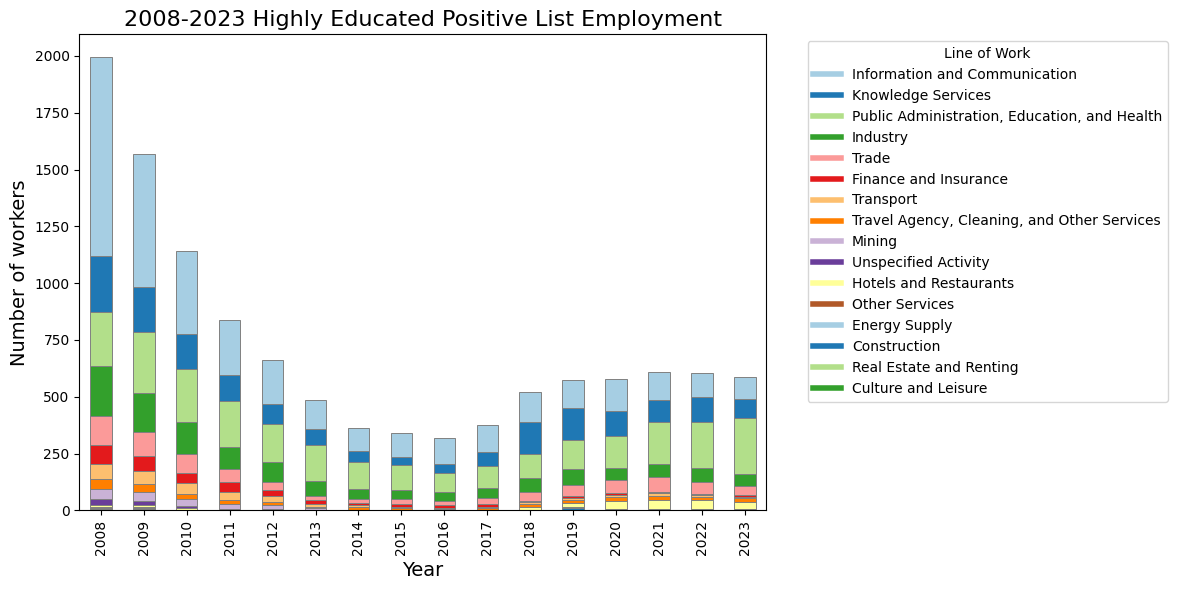

In [21]:
# Replace "." with NaN and convert columns from 2008-2023 to numeric
years = list(map(str, range(2008, 2024)))
df_high[years] = df_high[years].replace('.', pd.NA)
df_high[years] = df_high[years].apply(pd.to_numeric, errors='coerce')

# Filter out industries that have no data across all years
df_filtered = df_high.dropna(how='all', subset=years)

# Fill any remaining NaN values with 0 for plotting
df_filtered.loc[:, years] = df_filtered[years].fillna(0)

# Sort Branche by the values in 2008 in descending order (so largest ones come first in the legend)
branche_sorted_by_2008 = df_filtered[['Branche', '2008']].sort_values(by='2008', ascending=False)['Branche']

# Create a color palette and assign it to the Branche names, sorted by 2008
rainbow_colors = sns.color_palette("Paired", n_colors=len(branche_sorted_by_2008))
color_mapping = {branche: color for branche, color in zip(branche_sorted_by_2008, rainbow_colors)}

# Sort Branche values by size in ascending order for each year
df_sorted_by_size = pd.DataFrame()

for year in years:
    # Sort Branche by size in ascending order for each year
    df_sorted_year = df_filtered[['Branche', year]].sort_values(by=year, ascending=True)
    
    # Append to the sorted DataFrame, ensuring that Branche is preserved as the index
    df_sorted_by_size = pd.concat([df_sorted_by_size, df_sorted_year.set_index('Branche')], axis=1)

# Transpose the DataFrame to have years on the x-axis and Branche in order for coloring
df_transposed_sorted = df_sorted_by_size.T

# Set columns to Branche names for easier color assignment
df_transposed_sorted.columns = df_sorted_by_size.index

# Create a stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the stacked bar chart, keeping the color mapping consistent across years
# Apply colors based on sorted branche from 2008
df_transposed_sorted.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    color=[color_mapping[branche] for branche in df_transposed_sorted.columns],  # Use consistent colors
    edgecolor='grey',  
    linewidth=0.7  
)

# Add labels and title
plt.title('2008-2023 Highly Educated Positive List Employment', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of workers', fontsize=14)

# Generate correct handles and labels for the legend based on sorted branches
handles = [plt.Line2D([0], [0], color=color_mapping[branche], lw=4) for branche in branche_sorted_by_2008]
labels = list(branche_sorted_by_2008)

# Ensure the legend is sorted by the 2008 values and consistent with colors
plt.legend(handles=handles, labels=labels, title='Line of Work', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


This graph shows how many people are working in Denmark on this type of permit. 2008 when the scheme started, it was popular but many people either stopped working in Denmark or changed to another kind of residency status. 
The number of people working on this scheme granted started rising in 2017 but the most popular lines of work shifted from 'Information & Communication' to 'Public Administration, Education and Health'.

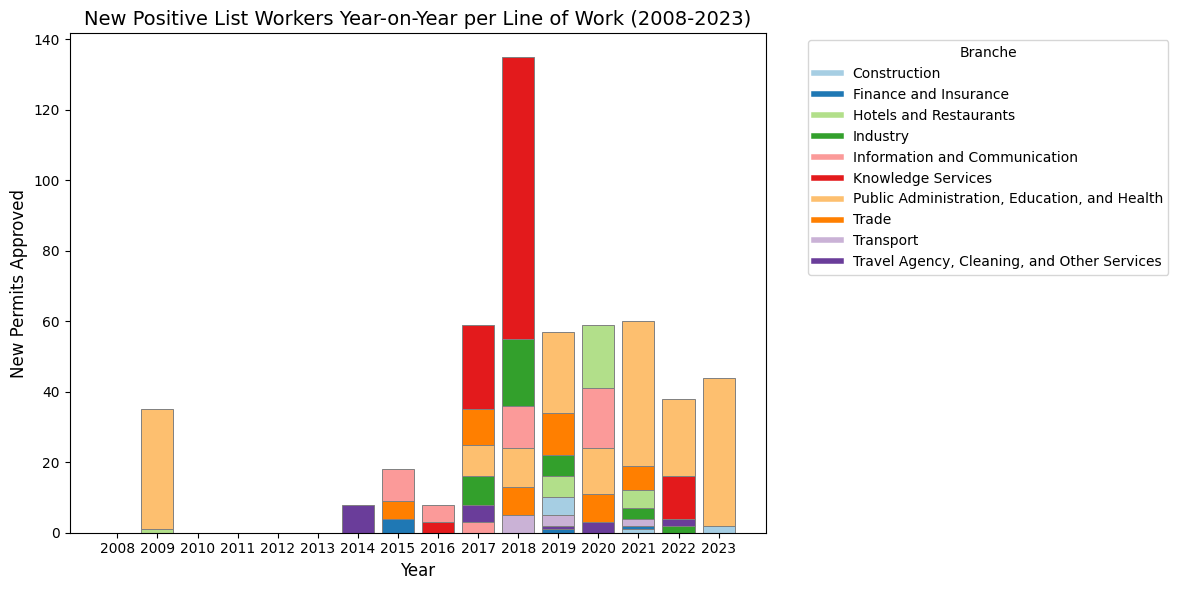

In [22]:
# Replace "." with NaN and convert columns from 2008-2023 to numeric
years = list(map(str, range(2008, 2024)))
df_high[years] = df_high[years].replace('.', pd.NA)  # Replace "." with NaN
df_high[years] = df_high[years].apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Filter out industries that have no data across all years
df_filtered = df_high.dropna(how='all', subset=years)

# Calculate the year-on-year changes (difference between consecutive years)
df_changes = df_filtered.set_index('Branche').diff(axis=1)

# Replace negative changes with 0 (so only positive changes are shown)
df_changes[df_changes < 0] = 0

# Drop branches where all the values across the years are 0 (no new permits)
df_changes = df_changes.loc[(df_changes.sum(axis=1) > 0)]

# Ensure that we handle any remaining NaN values by replacing them with 0
df_changes.fillna(0, inplace=True)

# Sort Branche names alphabetically to assign colors correctly
alphabetical_branches = sorted(df_changes.index)

paired_colors = sns.color_palette("Paired", n_colors=len(alphabetical_branches))
color_mapping = {branche: color for branche, color in zip(alphabetical_branches, paired_colors)}

# Initialize a plot
plt.figure(figsize=(12, 6))

# Initialize bottom positions for each year to stack bars
bottom = np.zeros(len(years))  # Start with zero for each year

# Loop through each year and sort the branches by ascending size for that year
for i, year in enumerate(years):
    # Get the sorted branche names for the current year based on values in ascending order
    sorted_branches = df_changes[year].sort_values(ascending=True).index

    # Plot the stacked bars for the current year in ascending order, using consistent colors
    for branche in sorted_branches:
        values = df_changes.loc[branche, year]
        plt.bar(year, values, bottom=bottom[i], color=color_mapping[branche], label=branche, edgecolor='grey',  
    linewidth=0.7 )
        # Update the bottom position for stacking
        bottom[i] += values

# Add labels and title
plt.title('New Positive List Workers Year-on-Year per Line of Work (2008-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('New Permits Approved', fontsize=12)

# Generate handles and labels for the legend based on alphabetical order
handles = [plt.Line2D([0], [0], color=color_mapping[branche], lw=4) for branche in alphabetical_branches]
labels = alphabetical_branches  # Alphabetical labels

# Ensure the legend is in alphabetical order and consistent with colors
plt.legend(handles=handles, labels=labels, title='Branche', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


This graph shows the number of *new* permits on the Positive List for highly educated foreigners. There was a significant increase in Knowledege Services in 2018 but the rest of the increases have been modest.

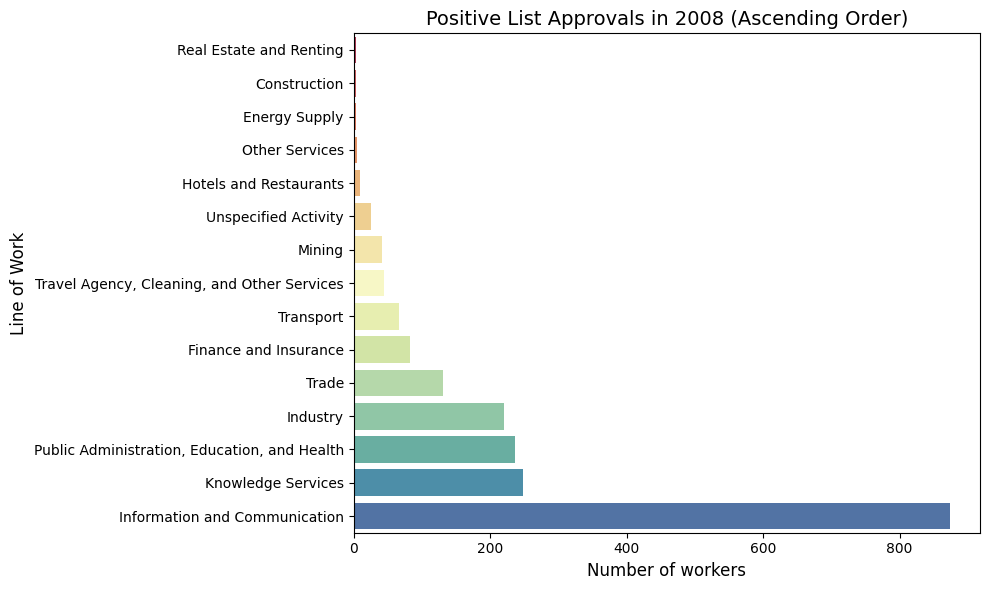

In [23]:
# Replace "." with NaN and convert 2008 column to numeric
df_filtered.loc[:, '2008'] = df_filtered['2008'].replace('.', pd.NA)  # Replace "." with NaN
df_filtered.loc[:, '2008'] = pd.to_numeric(df_filtered['2008'], errors='coerce')  # Convert to numeric

# Filter out rows where 2008 data is missing
df_2008 = df_filtered[['Branche', '2008']].dropna()

# Sort the data by 2008 in ascending order
df_2008_sorted = df_2008.sort_values(by='2008', ascending=True)

# Plot the data using Seaborn, assigning 'Branche' to 'hue' for color, but disabling the legend
plt.figure(figsize=(10, 6))
sns.barplot(x='2008', y='Branche', hue='Branche', data=df_2008_sorted, palette='Spectral', legend=False)

# Add labels and title
plt.title('Positive List Approvals in 2008 (Ascending Order)', fontsize=14)
plt.xlabel('Number of workers', fontsize=12)
plt.ylabel('Line of Work', fontsize=12)

plt.tight_layout()
plt.show()


This graph is a more detailed look at which lines of work were granted the original Positive List permission in 2008.

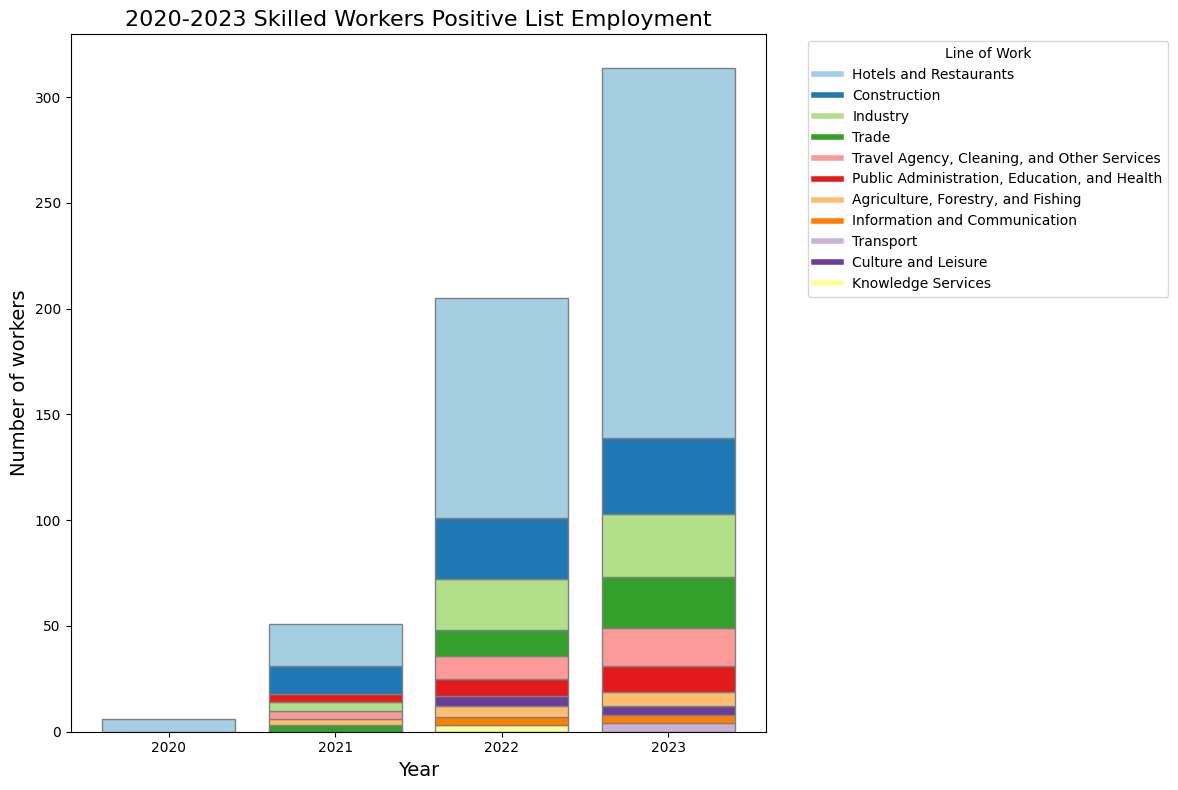

In [28]:
# Replace "." with NaN and convert columns from 2020-2023 to numeric
years = list(map(str, range(2020, 2024)))
df_skilled[years] = df_skilled[years].replace('.', pd.NA)
df_skilled[years] = df_skilled[years].apply(pd.to_numeric, errors='coerce')

# Filter out industries that have no data across all years
df_filtered = df_skilled.dropna(how='all', subset=years)

# Use .loc to avoid SettingWithCopyWarning when filling NaN values
df_filtered.loc[:, years] = df_filtered[years].fillna(0)

# Sort Branche by the values in 2023 in descending order (so largest ones come first in the legend)
branche_sorted_by_2023 = df_filtered[['Branche', '2023']].sort_values(by='2023', ascending=False)['Branche']

# Create a color palette and assign it to the Branche names
colors = sns.color_palette("Paired", n_colors=len(branche_sorted_by_2023))
color_mapping = {branche: color for branche, color in zip(branche_sorted_by_2023, colors)}

# Initialize a DataFrame to store sorted values
df_sorted_by_size = pd.DataFrame()

# Loop through each year and sort branches by value in ascending order
for year in years:
    # Sort Branche by size in ascending order for each year
    df_sorted_year = df_filtered[['Branche', year]].sort_values(by=year, ascending=True)
    
    # Append sorted DataFrame, ensuring that Branche is preserved as the index
    df_sorted_by_size = pd.concat([df_sorted_by_size, df_sorted_year.set_index('Branche')], axis=1)

# Transpose the DataFrame to have years on the x-axis and Branche as columns
df_transposed_sorted = df_sorted_by_size.T

# Make sure the columns (Branche) are in the order they were originally sorted by 2023
df_transposed_sorted.columns = df_sorted_by_size.index

# Create a stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the stacked bar chart, keeping the color mapping consistent across years
for year in years:
    # Sort Branche for each year in ascending order for consistent stacks, but use the same colors
    sorted_branches = df_transposed_sorted.loc[year].sort_values(ascending=True).index
    bottom = np.zeros(len(years))  # Reset the bottom for each year

    for branche in sorted_branches:
        plt.bar(year, df_transposed_sorted.loc[year, branche], bottom=bottom[int(year) - 2020], 
                color=color_mapping[branche], edgecolor='grey', label=branche)
        # Update bottom position for stacking
        bottom[int(year) - 2020] += df_transposed_sorted.loc[year, branche]

# Add labels and title
plt.title('2020-2023 Skilled Workers Positive List Employment', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of workers', fontsize=14)

# Generate correct handles and labels for the legend based on 2023 data
handles = [plt.Line2D([0], [0], color=color_mapping[branche], lw=4) for branche in branche_sorted_by_2023]
labels = list(branche_sorted_by_2023)

# Ensure the legend is sorted by the 2023 values and consistent with colors
plt.legend(handles=handles, labels=labels, title='Line of Work', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


These are the figures for people working in Denmark on the positive list for Skilled Workers.

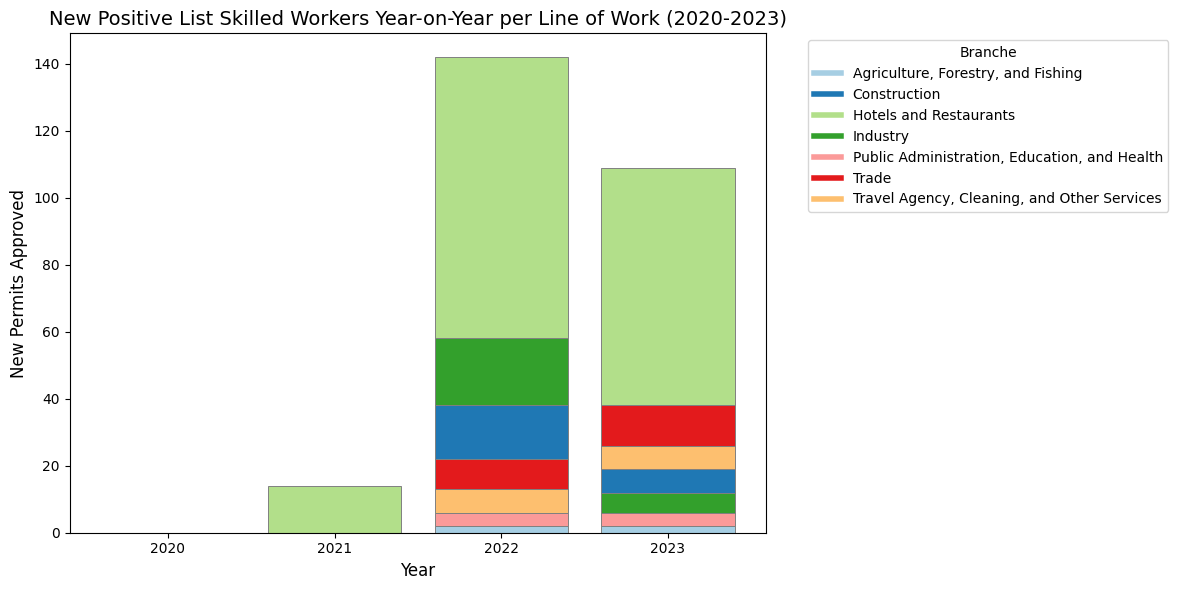

In [25]:
# Define the range of years (2020-2023)
years = list(map(str, range(2020, 2024)))

# Replace "." with NaN and convert columns from 2020-2023 to numeric
df_skilled[years] = df_skilled[years].replace('.', pd.NA)  # Replace "." with NaN
df_skilled[years] = df_skilled[years].apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Filter out industries that have no data across all years
df_filtered = df_skilled.dropna(how='all', subset=years)

# Calculate the year-on-year changes (difference between consecutive years)
df_changes = df_filtered.set_index('Branche').diff(axis=1)

# Replace negative changes with 0 (so only positive changes are shown)
df_changes[df_changes < 0] = 0

# Drop branches where all the values across the years are 0 (no new permits)
df_changes = df_changes.loc[(df_changes.sum(axis=1) > 0)]

# Ensure that we handle any remaining NaN values by replacing them with 0
df_changes.fillna(0, inplace=True)

# Sort Branche names alphabetically to assign colors correctly
alphabetical_branches = sorted(df_changes.index)

# Create a Paired color palette and assign it to the alphabetically sorted Branche names
paired_colors = sns.color_palette("Paired", n_colors=len(alphabetical_branches))
color_mapping = {branche: color for branche, color in zip(alphabetical_branches, paired_colors)}

# Initialize a plot
plt.figure(figsize=(12, 6))

# Initialize bottom positions for each year to stack bars
bottom = np.zeros(len(years))  # Start with zero for each year

# Loop through each year and sort the branches by ascending size for that year
for i, year in enumerate(years):
    # Get the sorted branche names for the current year based on values in ascending order
    sorted_branches = df_changes[year].sort_values(ascending=True).index

    # Plot the stacked bars for the current year in ascending order, using consistent colors
    for branche in sorted_branches:
        values = df_changes.loc[branche, year]
        plt.bar(year, values, bottom=bottom[i], color=color_mapping[branche], label=branche, edgecolor='grey', linewidth=0.7)
        # Update the bottom position for stacking
        bottom[i] += values

# Add labels and title
plt.title('New Positive List Skilled Workers Year-on-Year per Line of Work (2020-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('New Permits Approved', fontsize=12)

# Generate handles and labels for the legend based on alphabetical order
handles = [plt.Line2D([0], [0], color=color_mapping[branche], lw=4) for branche in alphabetical_branches]
labels = alphabetical_branches  # Alphabetical labels

# Ensure the legend is in alphabetical order and consistent with colors
plt.legend(handles=handles, labels=labels, title='Line of Work', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


These are the NEW positive list skilled workers since the scheme began.

# What are the nationalities we are talking about?

## Throat Clearing
*Despite being made for "third country" (as in, non-EU, non-Nordic) immigration, some EU and Nordic migrants have been accepted, presumably for the sake of their third country spouses.*

*Some people commute into Denmark on this scheme, so have not migrated into Denmark as such. Some do not have full time employment on this scheme.*

Let's just look at the third-country immigration for now:-

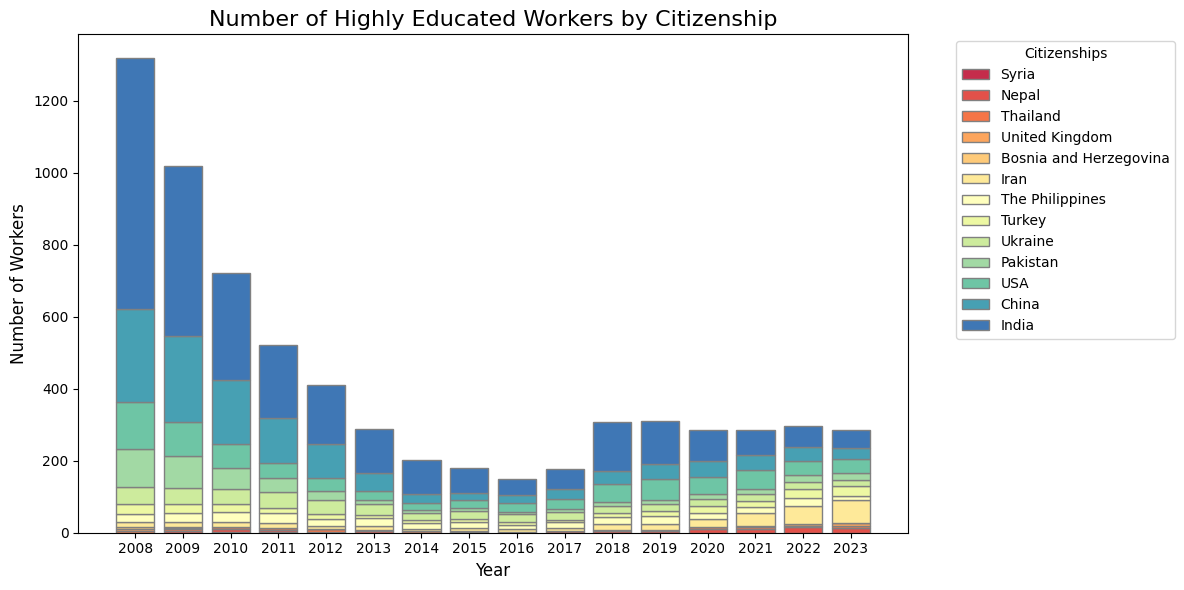

In [26]:
# Reshape the DataFrame using melt to make it long format
df_melted = df_cit_high.melt(id_vars='Citizenships', var_name='Year', value_name='Number of Workers')

# Convert 'Year' to a string type
df_melted['Year'] = df_melted['Year'].astype(str)

# Pivot the melted DataFrame to prepare for stacked bar chart
df_pivot = df_melted.pivot_table(index='Year', columns='Citizenships', values='Number of Workers', aggfunc='sum')

# Drop citizenships where the total number of workers is 0 across all years
df_pivot = df_pivot.loc[:, (df_pivot.sum(axis=0) > 0)]

# Sort each year in ascending order and concatenate into a new DataFrame
df_sorted_by_year = pd.concat([df_pivot.loc[year].sort_values(ascending=True).to_frame().T for year in df_pivot.index])


colors = sns.color_palette("Spectral", n_colors=len(df_sorted_by_year.columns))
color_mapping = {citizenship: color for citizenship, color in zip(df_sorted_by_year.columns, colors)}

# Create a stacked bar chart
plt.figure(figsize=(12, 6))
bottom = np.zeros(len(df_sorted_by_year))  # Initialize the bottom positions for stacking

# Plot each citizenship stack in ascending order for each year, keeping colors consistent
for citizenship in df_sorted_by_year.columns:
    plt.bar(df_sorted_by_year.index, df_sorted_by_year[citizenship], bottom=bottom, color=color_mapping[citizenship], edgecolor='grey', label=citizenship)
    bottom += df_sorted_by_year[citizenship].values

# Add labels and title
plt.title('Number of Highly Educated Workers by Citizenship', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Workers', fontsize=12)

# Display the legend outside the plot for better visibility
plt.legend(title='Citizenships', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


How interesting that they recruited so many from India and China under this scheme but the numbers dropped off... did they get another type of residency or leave?

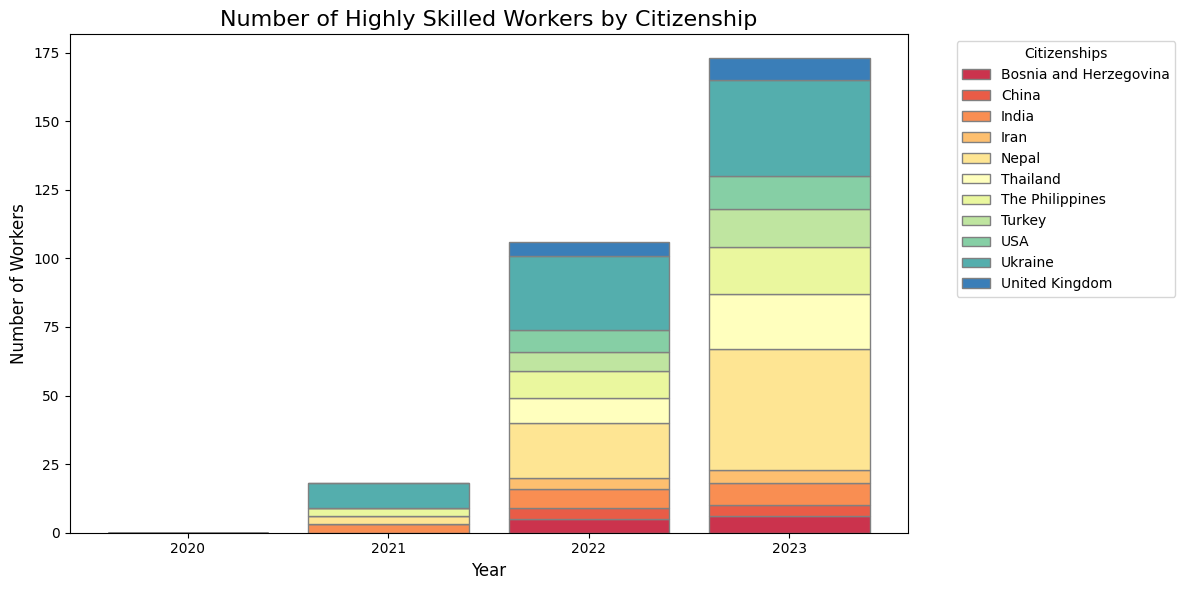

In [27]:
# Reshape the DataFrame using melt to make it long format
df_melted = df_cit_skilled.melt(id_vars='Citizenships', var_name='Year', value_name='Number of Workers')

# Convert 'Year' to a string type
df_melted['Year'] = df_melted['Year'].astype(str)

# Pivot the melted DataFrame to prepare for stacked bar chart
df_pivot = df_melted.pivot_table(index='Year', columns='Citizenships', values='Number of Workers', aggfunc='sum')

# Drop citizenships where the total number of workers is 0 across all years
df_pivot = df_pivot.loc[:, (df_pivot.sum(axis=0) > 0)]

# Sort each year in ascending order and concatenate into a new DataFrame
df_sorted_by_year = pd.concat([df_pivot.loc[year].sort_values(ascending=True).to_frame().T for year in df_pivot.index])


colors = sns.color_palette("Spectral", n_colors=len(df_sorted_by_year.columns))
color_mapping = {citizenship: color for citizenship, color in zip(df_sorted_by_year.columns, colors)}

# Create a stacked bar chart
plt.figure(figsize=(12, 6))
bottom = np.zeros(len(df_sorted_by_year))  # Initialize the bottom positions for stacking

# Plot each citizenship stack in ascending order for each year, keeping colors consistent
for citizenship in df_sorted_by_year.columns:
    plt.bar(df_sorted_by_year.index, df_sorted_by_year[citizenship], bottom=bottom, color=color_mapping[citizenship], edgecolor='grey', label=citizenship)
    bottom += df_sorted_by_year[citizenship].values

# Add labels and title
plt.title('Number of Highly Skilled Workers by Citizenship', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Workers', fontsize=12)

# Display the legend outside the plot for better visibility
plt.legend(title='Citizenships', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


🔮 Nepal is going to be a big player in Danish immigration in the future.

# Rejections
There are rules about income to prevent "social dumping" (where foreigners get worse working conditions and pay than locals). The wording is that the salary should be "ordinary", compared to national pay statistics. This means that some people are rejected because their compensation would be #higher# than ordinary. There have been some cases in the media about this rule making it difficult for employers to recruit in skills shortage areas. (https://ekstrabladet.dk/nyheder/samfund/straffet-for-at-give-ansat-mere-i-loen/8964271)

In the evaluation by SIRI, you can see the numbers of rejections in the Highly Skilled positive list are much higher than permissions granted (388 vs 264) and you can even see which exact professions have been getting permission 
https://www.ft.dk/samling/20222/almdel/UUI/bilag/71/2720734/index.htm 